<a href="https://colab.research.google.com/github/khanh22mse23057/python4engineer-assignments/blob/main/FinalAssignments_Practice%26Build_API_with_Superstore_Sales_Dataset_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bài tập lớn kết thúc môn

##  *Đặt vấn đề*

Cho tập dữ liệu về doanh số bán hàng gồm các thông tin như sau:
[Input Data](https://drive.google.com/file/d/1QWD8rceAWo6KJYHh6Tx0eBtAM9U1EQno/view?usp=sharing(sad)

[Superstore Sales Dataset Analysis | Kaggle ](https://www.kaggle.com/code/adamossama/superstore-sales-dataset-analysis/data)
- order_id
- order_date
- ship_date
- ship_mode
- customer_id
- customer_name
- segment
- country
- city
- state
- region
- product_id
- sub-category
- product_name
- sales

Hãy sử dụng Python và Jupyter Notebook để trả lời các câu hỏi sau



## Cài đặt môi trường

In [ ]:
# Trước hết, cần install Python và package Kaggle
# Một số functions trong bài không work với latest version, nên cài đặt packages version chỉ định như sau
!pip install opendatasets
!pip install pandas
!pip install pystan
!pip install kaggle
!pip install unzip


## Chuẩn bị dữ liệu
1. Option 1:
Để truy cập được tệp data từ Kaggle, cần phải tạo key và cấu hình môi trường

Ví dụ file secret key được tạo từ Kaggle và được lấy về từ github. Cách tạo key : https://prnt.sc/UCwb6zgoPzYT
* Lưu ý: Kaggle yêu cầu xác thực tài khoản bằng số điện thoại để cấp cấp quyền truy cập dữ liệu.
2. Option 2: Upload file lên google drive hoặc github: 
* Bài viết này sử dụng cách này

#### Import thư viện

In [195]:
import datetime
import itertools
import statsmodels.api as sm # Statsmodels là một gói Python cho phép người dùng khám phá dữ liệu : https://www.statsmodels.org/stable/index.html
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns # Dùng thêm lib này để vẽ biểu đồ cho đẹp ^.^

from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings("ignore") # Ẩn warnings khi runtime, nếu muốn xem uncomment

# pd.set_option('max_columns', 25) #some columns will be truncated otherwise, setting to number of columns in sales

sns.set_style("ticks")
sns.set(font_scale = 1.5)

%matplotlib inline

In [196]:
# Load data
train_raw_url = "https://raw.githubusercontent.com/khanh22mse23057/kaggle-sales-dataset-train/main/superstore_sales.csv"

# Đọc dữ liệu từ file csv vào data frame
train_sales = pd.read_csv(train_raw_url)

# Check dữ liệu vs 5 row đầu
train_sales.head(5)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


#### Load dữ liệu

Tìm hiểu dữ liệu đầu vào

In [197]:
print('-----------------------------train_sales-----------------------------------------')
train_sales.info()

print('-----------------------------Check Category--------------------------------------')
train_sales['Category'].value_counts()
print(train_sales['Category'].unique())

print('-----------------------------Check Sub-Category--------------------------------------')
print(train_sales['Sub-Category'].unique())
no_of_subcategory=train_sales['Sub-Category'].nunique()
print("Categories are divided into %d subcategories"%no_of_subcategory)


print('-----------------------------Check State--------------------------------------')
print(train_sales['State'].unique())
no_of_states=train_sales['State'].nunique()
print("There are %d states in this df."%no_of_states)

print('-----------------------------Check City--------------------------------------')
# Uncomment nếu muốn xem tất cả các city
# print(train_sales['City'].unique())
# cities=train_sales['City'].nunique()
# print("There are %d city in this df."%cities)

# train_sales['Segment'].value_counts()
#displaying the sum of duplicated values if there are any
train_sales.duplicated().sum()


-----------------------------train_sales-----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name  

0

In [198]:
train_sales.nunique() 

Row ID           9800
Order ID         4922
Order Date       1230
Ship Date        1326
Ship Mode           4
Customer ID       793
Customer Name     793
Segment             3
Country             1
City              529
State              49
Postal Code       626
Region              4
Product ID       1861
Category            3
Sub-Category       17
Product Name     1849
Sales            5757
dtype: int64

In [199]:
train_sales.isnull().sum()

Row ID            0
Order ID          0
Order Date        0
Ship Date         0
Ship Mode         0
Customer ID       0
Customer Name     0
Segment           0
Country           0
City              0
State             0
Postal Code      11
Region            0
Product ID        0
Category          0
Sub-Category      0
Product Name      0
Sales             0
dtype: int64

In [200]:
train_sales.describe()

,Row ID,Postal Code,Sales
count,9800.000000,9789.000000,9800.000000
mean,4900.500000,55273.322403,230.769059
std,2829.160653,32041.223413,626.651875
min,1.000000,1040.000000,0.444000
25%,2450.750000,23223.000000,17.248000
50%,4900.500000,58103.000000,54.490000
75%,7350.250000,90008.000000,210.605000
max,9800.000000,99301.000000,22638.480000


In [201]:
train_sales.shape

(9800, 18)

==> Qua kết quả cho thấy dữ liệu OK ngoại trừ Postal Code có 11 dữ liệu ko tìm thấy trên tổng 9800 records

In [202]:
data = train_sales.copy() 

## Câu 1.Tiền xử lý dữ liệu 
(xử lý các trường hợp thiếu dữ liệu, chuẩn hóa ngày tháng, đơn vị,...).

In [203]:
#convert datetime columns to datetime objects
# data['Order Date'] = pd.to_datetime(data['Order Date'], dayfirst=True)
# data['Ship Date'] = pd.to_datetime(data['Ship Date'], dayfirst=True)
# data.info()

In [204]:
# Cleaning data
data['Postal Code'] = data['Postal Code'].astype('object') 
data["Postal Code"] = data["Postal Code"].fillna(0)
data["Order Date"] = pd.to_datetime(data["Order Date"], format="%d/%m/%Y")
data["Ship Date"] = pd.to_datetime(data["Ship Date"], format="%d/%m/%Y")

#formatting the date column correctly
# data.Order_Date= data["Order Date"].apply(lambda x:datetime.datetime.strptime(x, '%m/%d/%y'))
# data.Ship_Date= data["Ship Date"].apply(lambda x:datetime.datetime.strptime(x, '%m/%d/%y'))

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9800 non-null   int64         
 1   Order ID       9800 non-null   object        
 2   Order Date     9800 non-null   datetime64[ns]
 3   Ship Date      9800 non-null   datetime64[ns]
 4   Ship Mode      9800 non-null   object        
 5   Customer ID    9800 non-null   object        
 6   Customer Name  9800 non-null   object        
 7   Segment        9800 non-null   object        
 8   Country        9800 non-null   object        
 9   City           9800 non-null   object        
 10  State          9800 non-null   object        
 11  Postal Code    9800 non-null   float64       
 12  Region         9800 non-null   object        
 13  Product ID     9800 non-null   object        
 14  Category       9800 non-null   object        
 15  Sub-Category   9800 n

In [205]:
# sales = data.loc[:, ["Order Date", "Sales"]]
# sales.info()

## Câu 2.Vẽ biểu đồ thể hiện biến động doanh thu theo tháng


Text(0, 0.5, 'Revenue (USD)')

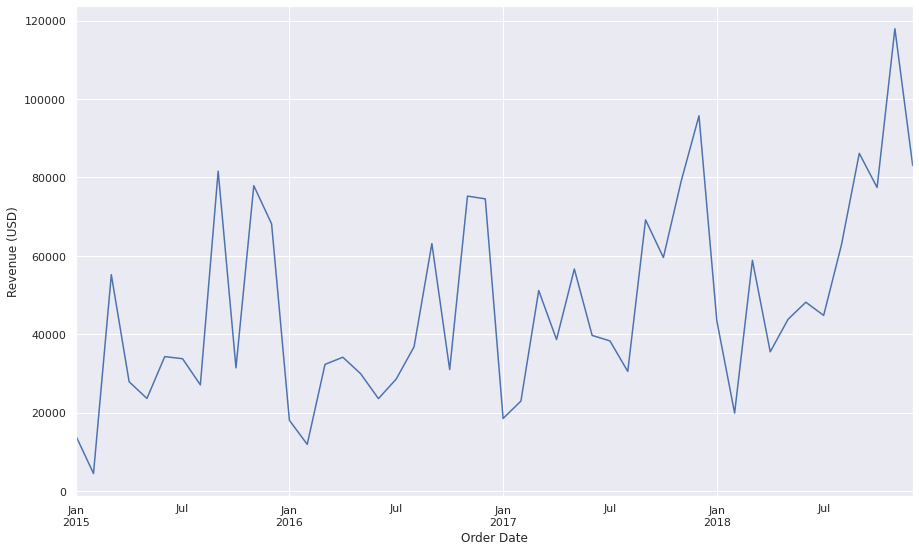

In [206]:
# # Revenue by month
sns.set(rc={'figure.figsize':(15,9)})
revenue_by_month = data.groupby(pd.Grouper(key="Order Date", freq="M"))["Sales"].sum()
plt = revenue_by_month.plot()
plt.set_ylabel("Revenue (USD)")

In [207]:
# print(revenue_by_month)

Cho biết doanh thu trung bình trong 3 tháng gần nhất.

In [208]:
mean_revenue = revenue_by_month.reset_index().sort_values(by="Order Date", ascending=True)[-3:]
print(mean_revenue)
# Mean revenue in nearest 3 months
print("Mean revenue in nearest 3 months: ${:0,.2f}".format(mean_revenue["Sales"].mean()))

   Order Date        Sales
45 2018-10-31   77448.1312
46 2018-11-30  117938.1550
47 2018-12-31   83030.3888
Mean revenue in nearest 3 months: $92,805.56


## Câu 3.Vẽ biểu đồ doanh số bán hàng theo quý 


Text(0, 0.5, 'Revenue (USD)')

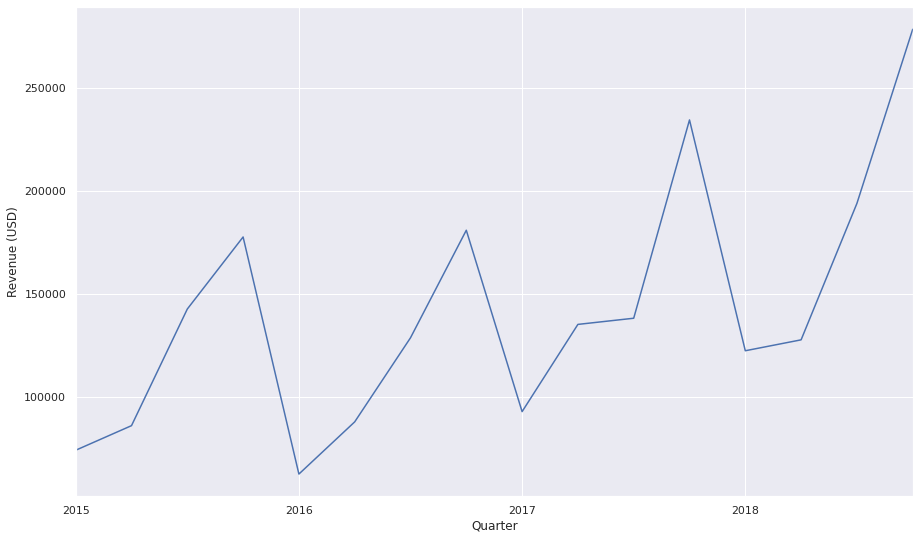

In [209]:
# Revenue by quarter
revenue_by_quarter_data = data.groupby(pd.Grouper(key="Order Date", freq="Q"))["Sales"].sum()
revenue_by_quarter = revenue_by_quarter_data.plot()
revenue_by_quarter.set_xlabel("Quarter")
revenue_by_quarter.set_ylabel("Revenue (USD)")

#### Xác định quý nào có tổng doanh số cao nhất

In [210]:
# Quarter with highest revenue
highest_quarter = revenue_by_quarter_data.idxmax()
highest_quarter_revenue = revenue_by_quarter_data[highest_quarter]

# Print top 3 
# print(highest_quarter_revenue[:3])

prd = pd.Period(freq="S", value=highest_quarter) 
# print(highest_quarter_revenue)
print("\n Quarter with highest revenue: \n Q{} {} \n Revenue: ${:0,.2f}".format(prd.quarter, highest_quarter.strftime("%d/%m/%Y"), highest_quarter_revenue))


 Quarter with highest revenue: 
 Q4 31/12/2018 
 Revenue: $278,416.67


## Câu 4.Tính thời gian trung giao hàng trung bình

In [211]:
# Mean delivery time
# pd.to_datetime(data['Order Date']).dt.to_period('M')
_data_t = data
_data_t["Delivery Time"] = (_data_t["Ship Date"] - _data_t["Order Date"])

delivery_time_mean = _data_t.groupby(pd.Grouper(key="Order Date", freq="M"))["Delivery Time"].mean(numeric_only=False)
delivery_time_mean = delivery_time_mean.reset_index(name =  "Delivery Time Mean")
delivery_time_mean["Order Date"] = delivery_time_mean["Order Date"].dt.to_period(freq = 'M')
delivery_time_mean.rename(columns={'Order Date': 'Month'})
print(delivery_time_mean)


   Order Date        Delivery Time Mean
0     2015-01 4 days 04:40:31.168831168
1     2015-02 4 days 04:10:26.086956521
2     2015-03 3 days 23:03:53.766233766
3     2015-04 4 days 00:22:09.230769230
4     2015-05 3 days 19:14:22.809917355
5     2015-06 4 days 05:07:47.175572519
6     2015-07 3 days 20:16:54.084507042
7     2015-08 4 days 02:08:13.150684931
8     2015-09 4 days 01:20:53.932584269
9     2015-10 3 days 08:36:13.584905660
10    2015-11 4 days 05:57:38.823529411
11    2015-12 3 days 23:02:11.386861313
12    2016-01 4 days 17:41:03.157894736
13    2016-02           4 days 05:15:00
14    2016-03           3 days 18:22:30
15    2016-04           4 days 08:00:00
16    2016-05 4 days 00:30:12.587412587
17    2016-06 4 days 03:54:25.116279069
18    2016-07 3 days 18:52:56.470588235
19    2016-08 3 days 22:56:12.151898734
20    2016-09 4 days 08:10:06.315789473
21    2016-10 3 days 14:38:02.926829268
22    2016-11 3 days 23:28:35.887850467
23    2016-12 3 days 22:32:01.543408360


### Trực quan thời gian trung bình giao hàng

Text(0, 0.5, 'Mean Delivery Time (Days)')

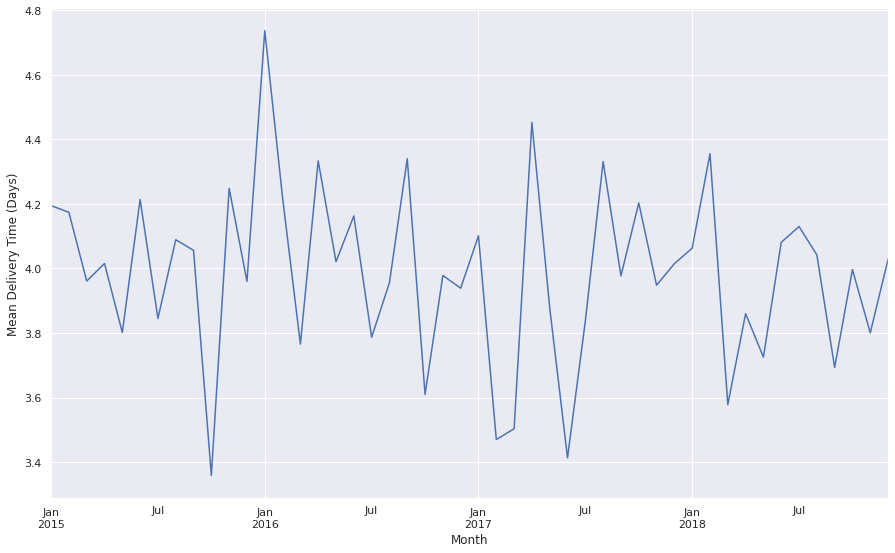

In [212]:
# Tính thời gian giao hàng = ngày giao - ngày đặt hàng
_data_t["Delivery Time"] = (_data_t["Ship Date"] - _data_t["Order Date"]).dt.days
mean_delivery_time_by_month = _data_t.groupby(pd.Grouper(key="Order Date", freq="M"))["Delivery Time"].mean().plot()

mean_delivery_time_by_month.set_xlabel("Month")
mean_delivery_time_by_month.set_ylabel("Mean Delivery Time (Days)")

## Câu 5.Vẽ biểu đồ thể hiện sức mua theo từng thành phố

In [213]:
sns.set(rc={'figure.figsize':(15,9)})

In [214]:
# Tính doanh thu theo city
revenue_by_city_data = data.groupby("City")["Sales"].sum()
revenue_by_city_data.sort_values()

City
Abilene               1.392
Elyria                1.824
Jupiter               2.064
Pensacola             2.214
Ormond Beach          2.808
                    ...    
Philadelphia     108841.749
San Francisco    109041.120
Seattle          116106.322
Los Angeles      173420.181
New York City    252462.547
Name: Sales, Length: 529, dtype: float64

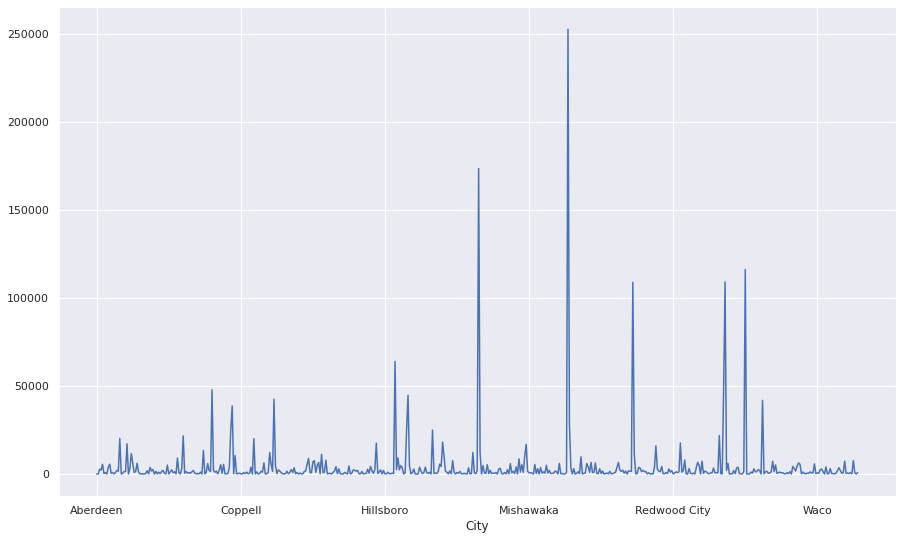

In [215]:
plt = revenue_by_city_data.plot()

#### Xác định top 3 thành phố có doanh số thấp nhất


In [216]:
# Top 3 City with lowest revenue
worst_sales_city = revenue_by_city_data.nsmallest(3)
# worst_sales_city.reset_index(name="Sales")
print(worst_sales_city.reset_index())


      City  Sales
0  Abilene  1.392
1   Elyria  1.824
2  Jupiter  2.064


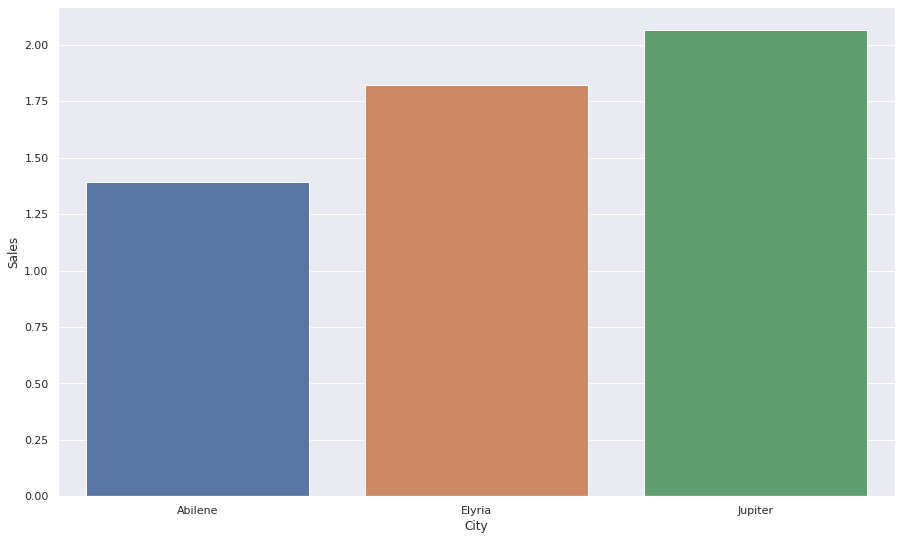

In [217]:
#Làm thêm: Vẽ biểu đồ trực quan
sns.barplot(x='City',y='Sales',data=worst_sales_city.reset_index())
# plt.xticks(rotation = 'vertical')

#### Xác định Top 3 thành phố có doanh số cao nhất

In [218]:
# Top 3 City with highest revenue
best_sales_cities = revenue_by_city_data.nlargest(3)
print(best_sales_cities.reset_index())

            City       Sales
0  New York City  252462.547
1    Los Angeles  173420.181
2        Seattle  116106.322


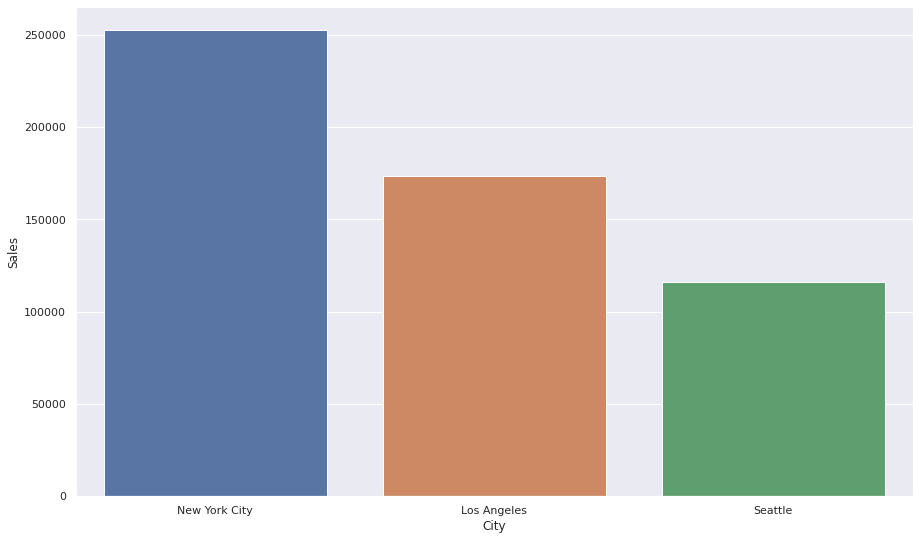

In [219]:
#Làm thêm: Vẽ biểu đồ trực quan
sns.barplot(x='City',y='Sales',data=best_sales_cities.reset_index())


## Câu 6.Vẽ biểu đồ thể hiện tỉ trọng doanh số theo bang (state)

In [220]:
# Cách trực quan theo biểu đồ pie
import plotly.express as px
df = data.groupby("State")["Sales"].sum()
df.reset_index(name="Sales")

fig = px.pie(df.reset_index(), values='Sales', names='State', title='Biểu đồ tỉ trọng doanh thu từng bang', height=900,width=1100)
fig.show()

# Cách khác nhưng hơi củ chuối
# sns.set(rc={'figure.figsize':(18,18)})
# import matplotlib.patches as mpatches
# # Percentage of revenue by State
# # tạo biểu dồ dạng hình tròn
# import plotly.express as px

# revenue_by_state_data = data.groupby("State")["Sales"].sum()
# revenue_by_state_data.plot(kind="pie",autopct='%0.2f%%', title = 'Biểu đồ tỉ trọng doanh thu từng bang')


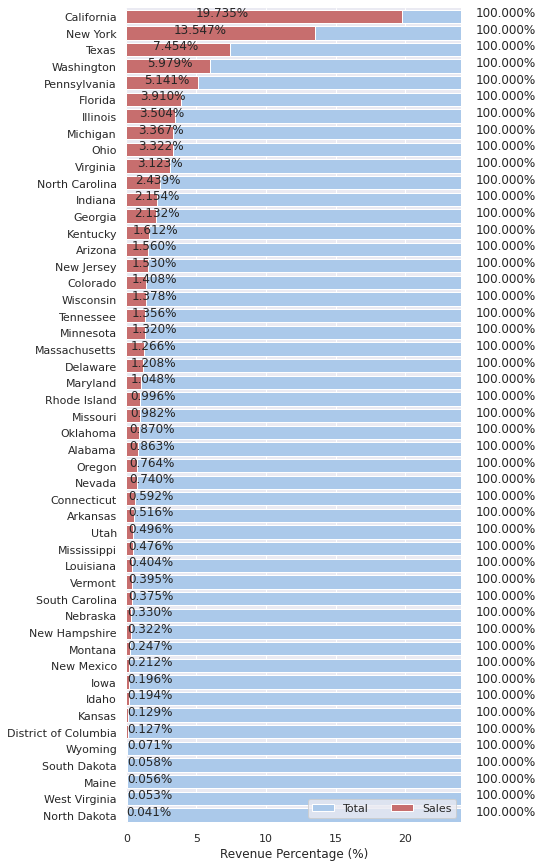

In [221]:
# Cách trực quan theo biểu đồ Horizontal bar plots
import seaborn as sns
import matplotlib.pyplot as plt

# Đoạn func này để hiển thị value cho cái bar
def show_values(axs, orient="v", space=.01, symbol ="", x_label = "", y_label = ""):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = ('{:.3f}' + symbol).format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 4 + float(space) # chổ này tính khoản cách label được hiển thị trên trục x
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5) 
                value = ('{:.3f}'+ symbol).format(p.get_width())
                ax.text(_x, _y, value, ha="left")

                # ax.set_ylabel = y_label
    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

revenue_by_state_data = data.groupby("State")["Sales"].sum().reset_index(name="Sales")
revenue_by_state_data.sort_values("Sales", ascending=False)
total_sale = revenue_by_state_data["Sales"].sum()

revenue_by_state_data["Rate"] = revenue_by_state_data["Sales"] / total_sale * 100 # Tính tỉ lệ % của các bàng trên tổng doanh thu
revenue_by_state_data["Per"] = 100 # Mask dữ liệu cột y là 100%
revenue_by_state_data = revenue_by_state_data.sort_values("Sales", ascending=False) # Sort lại dữ liệu để hiện thị giảm dần theo tỉ lệ %

# # Plot the total revenue_by_state_data
f, ax = plt.subplots(figsize=(6, 15))
sns.set_color_codes("pastel")
sns.barplot(x="Per", y="State", data=revenue_by_state_data, label="Total", color="b")

# # Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
p = sns.barplot(x="Rate", y="State", data=revenue_by_state_data, label="Sales", color="r")
show_values(p, "h", space=0.01,symbol= "%", x_label="100%")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 24), ylabel="", xlabel="Revenue Percentage (%)")
sns.despine(left=True, bottom=True)


In [222]:
sns.set(rc={'figure.figsize':(12,12)})

#### Xác định trung bình doanh số của 5 bang dẫn đầu về sức mua.

In [223]:
revenue_by_state = data.groupby("State")["Sales"].sum()
revenue_by_state = revenue_by_state.nlargest(5)
revenue_by_state.reset_index(name="Sales")

,State,Sales
0,California,446306.4635
1,New York,306361.1470
2,Texas,168572.5322
3,Washington,135206.8500
4,Pennsylvania,116276.6500


In [224]:
# Mean Top 5 State by sale
# revenue_by_state = data.groupby("State")["Sales"].sum()
mean_sales_top_5_state = revenue_by_state.nlargest(5).mean()
print("Mean of top 5 state by sale: ${:0,.2f}".format(mean_sales_top_5_state))

Mean of top 5 state by sale: $234,544.73


## Câu 7.Cho biết các bang dẫn đầu doanh số theo từng vùng
(east, west, south, central,..)

In [225]:
# Top states in revenue by Region
revenue_by_region_state_data = data.groupby(["Region", "State"])["Sales"].sum().reset_index()
# revenue_by_region_state_data
query_mask = revenue_by_region_state_data["Sales"] == revenue_by_region_state_data.groupby("Region")["Sales"].transform("max")
print(revenue_by_region_state_data[query_mask].sort_values(by="Sales"))

     Region       State        Sales
29    South     Florida   88436.5320
11  Central       Texas  168572.5322
21     East    New York  306361.1470
39     West  California  446306.4635


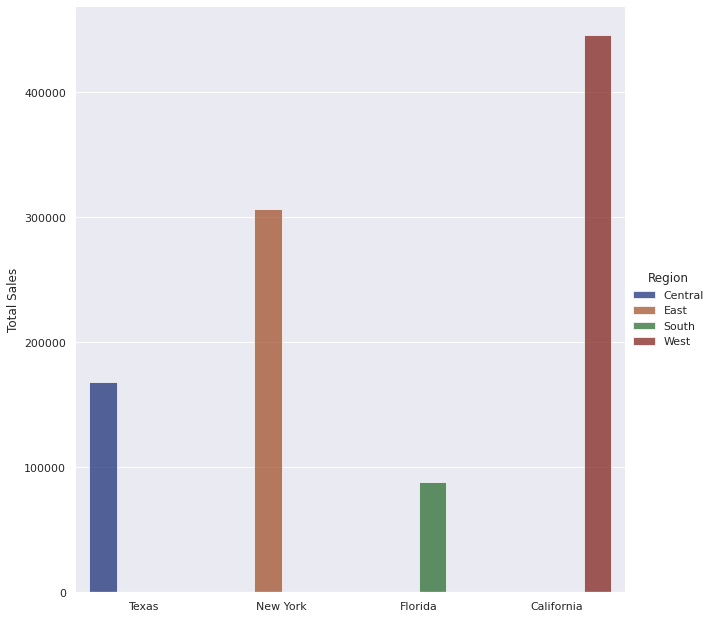

In [226]:
# Làm thêm : vẽ biểu đồ trực quan
src = revenue_by_region_state_data[query_mask]
# Draw a nested barplot by Sales and State
g = sns.catplot(data=src, kind="bar",
    x="State", y="Sales", hue="Region", palette="dark", alpha=.7, height=9)
g.despine(left=True)
g.set_axis_labels("", "Total Sales")


## Câu 8.Xác định top 3 sản phẩm có doanh thu cao nhất và top 3 sản phẩm có số lượng đơn vị bán ra cao nhất

#### Top 3 sản phẩm có doanh thu cao nhất 

In [227]:
# Top 3 products with highest revenue
# Cách 1:
sum_revenue_by_product = data.groupby(["Product ID", "Product Name"])["Sales"].sum()
print(sum_revenue_by_product.nlargest(3))

Product ID       Product Name                                                               
TEC-CO-10004722  Canon imageCLASS 2200 Advanced Copier                                          61599.824
OFF-BI-10003527  Fellowes PB500 Electric Punch Plastic Comb Binding Machine with Manual Bind    27453.384
TEC-MA-10002412  Cisco TelePresence System EX90 Videoconferencing Unit                          22638.480
Name: Sales, dtype: float64


In [228]:
# sns.barplot(data=sum_revenue_by_product.nlargest(3).reset_index(), x="Product ID", y = "Sales")

In [229]:
#Cách 2:  => làm thêm
# productSales = data.groupby('Product ID').agg({'Sales': 'sum'}).sort_values('Sales',ascending=False)[:3]

# #Vẽ biểu đổ top 3 sản phẩm bán chạy
# sns.barplot(x='Product ID',y='Sales',data=productSales.reset_index())
# plt.xticks(rotation = 'vertical')

#### Top 3 sản phẩm có số lượng đơn vị bán ra cao nhất

In [230]:
# Top 3 products with highest quantity
count_revenue_by_product = data.groupby(["Product ID", "Product Name"])["Sales"].count()
print(count_revenue_by_product.nlargest(3))

Product ID       Product Name                                             
FUR-CH-10002647  Situations Contoured Folding Chairs, 4/Set                   15
TEC-AC-10003628  Logitech 910-002974 M325 Wireless Mouse for Web Scrolling    15
FUR-CH-10002880  Global High-Back Leather Tilter, Burgundy                    14
Name: Sales, dtype: int64


## Câu 9.Vẽ biểu đồ thể hiện tỉ trọng doanh số của từng category

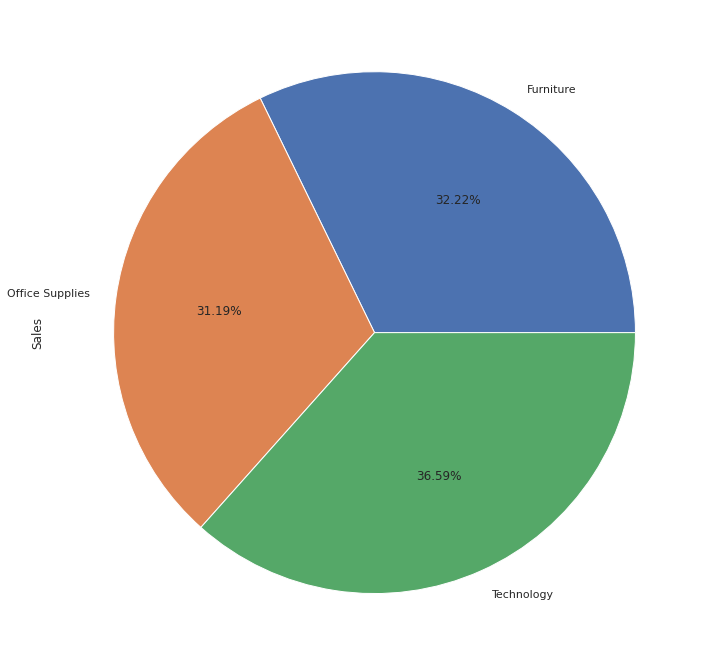

In [231]:
# Percentage of revenue by Category
revenue_by_category_data = data.groupby("Category")["Sales"].sum()
revenue_by_category_data.plot(kind="pie", autopct='%0.2f%%')

## Câu 10.Dự báo doanh số theo nhiều khía cạnh khác nhau trong tương lai: 
theo vùng, theo bang, theo category

### ỨNG DỤNG MÔ HÌNH ARIMA ĐỂ DỰ BÁO

#### Dự báo trên danh mục sản phẩm

In [256]:
#Theo dữ liệu đầu vào, quan sát trên dữ liệu category
# -----------------------------Check Category--------------------------------------
# ['Furniture' 'Office Supplies' 'Technology']

furniture = data.loc[data['Category']== 'Furniture']
furniture.head(5)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Delivery Time
0,1,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,3
1,2,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3
3,4,US-2016-108966,2016-10-11,2016-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,7
5,6,CA-2015-115812,2015-06-09,2015-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032.0,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,5
10,11,CA-2015-115812,2015-06-09,2015-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032.0,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,5


In [233]:
furniture.columns


Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Delivery Time'],
      dtype='object')

In [234]:
r_col = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name',  'Delivery Time']

furniture.drop(r_col, axis =1, inplace=True)

In [235]:
furniture

,Order Date,Sales
0,2017-11-08,261.9600
1,2017-11-08,731.9400
3,2016-10-11,957.5775
5,2015-06-09,48.8600
10,2015-06-09,1706.1840
...,...,...
9786,2015-11-05,149.9000
9787,2018-03-27,1023.3320
9788,2018-03-27,600.5580
9790,2018-03-27,211.2460


In [236]:
furniture = furniture.sort_values('Order Date')
furniture

,Order Date,Sales
7474,2015-01-06,2573.820
7660,2015-01-07,76.728
866,2015-01-10,51.940
716,2015-01-11,9.940
4938,2015-01-13,333.999
...,...,...
7632,2018-12-29,1207.840
1877,2018-12-29,393.568
7635,2018-12-29,300.980
5457,2018-12-29,68.460


In [237]:
furniture  = furniture.set_index('Order Date')
furniture

,Sales
Order Date,
2015-01-06,2573.820
2015-01-07,76.728
2015-01-10,51.940
2015-01-11,9.940
2015-01-13,333.999
...,...
2018-12-29,1207.840
2018-12-29,393.568
2018-12-29,300.980


In [238]:
furniture_y = furniture['Sales'].resample('MS').mean()
furniture_y

Order Date
2015-01-01    327.225105
2015-02-01    262.808286
2015-03-01    445.105250
2015-04-01    305.570654
2015-05-01    288.032792
2015-06-01    453.261434
2015-07-01    327.910636
2015-08-01    309.791761
2015-09-01    425.294300
2015-10-01    384.507719
2015-11-01    357.850678
2015-12-01    419.689623
2016-01-01    782.662773
2016-02-01    284.943091
2016-03-01    335.486054
2016-04-01    317.445409
2016-05-01    312.498350
2016-06-01    301.638840
2016-07-01    350.436923
2016-08-01    301.206006
2016-09-01    456.098600
2016-10-01    333.271071
2016-11-01    397.335533
2016-12-01    362.099225
2017-01-01    346.488318
2017-02-01    206.607947
2017-03-01    306.816550
2017-04-01    377.488286
2017-05-01    363.233537
2017-06-01    355.729257
2017-07-01    339.723216
2017-08-01    425.359225
2017-09-01    330.314505
2017-10-01    256.804543
2017-11-01    392.390479
2017-12-01    446.402012
2018-01-01    269.552818
2018-02-01    270.975096
2018-03-01    286.669600
2018-04-01    

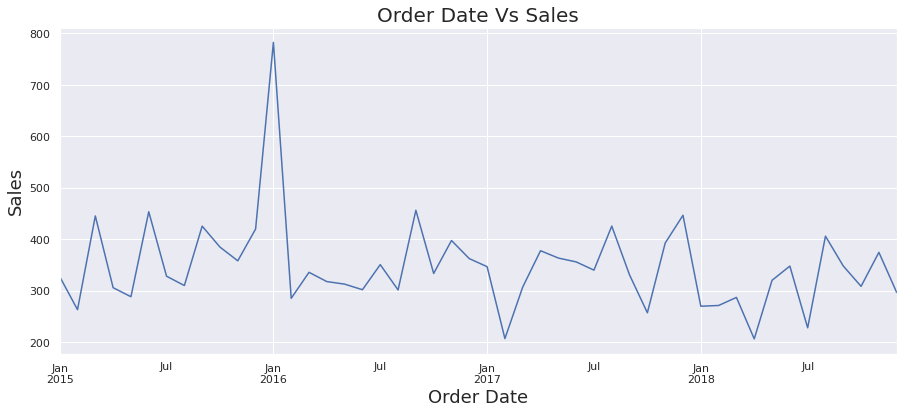

In [239]:
furniture_y.plot(figsize=(15,6))
plt.ylabel("Sales",fontsize=18)
plt.xlabel("Order Date",fontsize=18)
plt.title("Order Date Vs Sales", fontsize=20)
plt.show()

In [240]:
from pylab import rcParams as rc

rc['figure.figsize']= 10, 14
decomposition = sm.tsa.seasonal_decompose(furniture_y,model='additive')

# y(t) = Level + Trend + Seasonality + Noise --> Additive
print('-----------------------------Trend-----------------------------------------')
print(decomposition.trend)
print('-----------------------------Seasonal--------------------------------------')
print(decomposition.seasonal)
print('-----------------------------Residual--------------------------------------')
print(decomposition.resid)
print('-----------------------------Observed--------------------------------------')
print(decomposition.observed)

-----------------------------Trend-----------------------------------------
Order Date
2015-01-01           NaN
2015-02-01           NaN
2015-03-01           NaN
2015-04-01           NaN
2015-05-01           NaN
2015-06-01           NaN
2015-07-01    377.897256
2015-08-01    397.796109
2015-09-01    394.150926
2015-10-01    390.078241
2015-11-01    391.592421
2015-12-01    386.294211
2016-01-01    380.915198
2016-02-01    381.496054
2016-03-01    382.421826
2016-04-01    381.570479
2016-05-01    381.080821
2016-06-01    380.326423
2016-07-01    359.752887
2016-08-01    338.314987
2016-09-01    333.856460
2016-10-01    335.163684
2016-11-01    339.779437
2016-12-01    344.147170
2017-01-01    345.954533
2017-02-01    350.681180
2017-03-01    350.613227
2017-04-01    342.186117
2017-05-01    338.793968
2017-06-01    342.100540
2017-07-01    342.407510
2017-08-01    341.883829
2017-09-01    343.726337
2017-10-01    335.743390
2017-11-01    326.796582
2017-12-01    324.654535
2018-01-01   

<function matplotlib.pyplot.show(*args, **kw)>

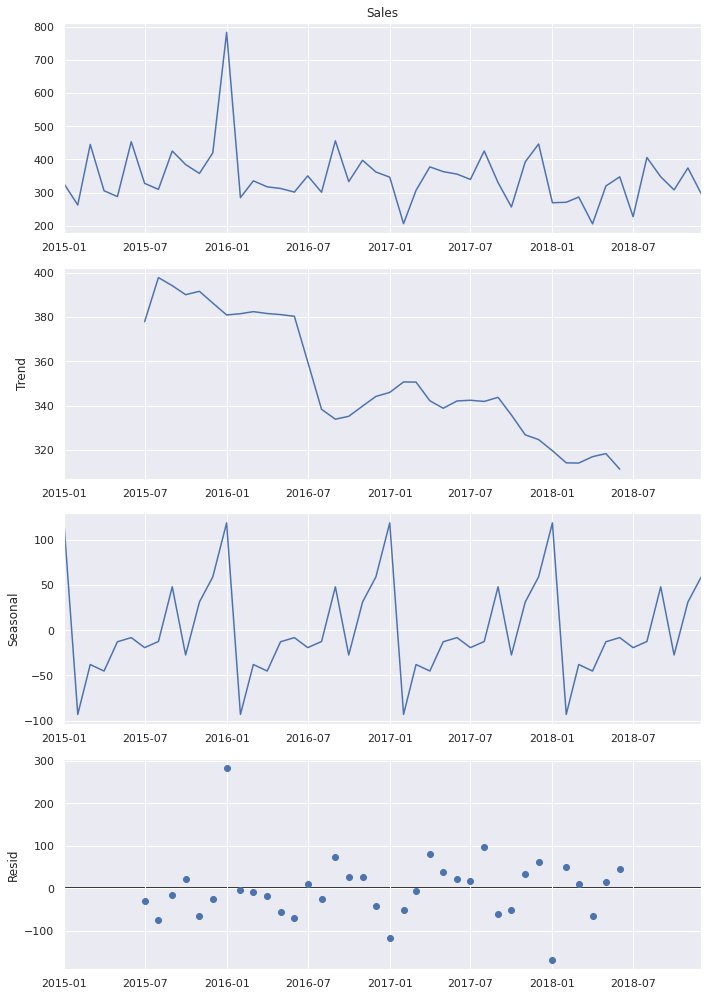

In [241]:
fig = decomposition.plot()
plt.show

In [242]:
# Lựa chọn tham số ARIMA(p, d, q)
p=d=q=range(0,2)
p,d,q

(range(0, 2), range(0, 2), range(0, 2))

In [243]:
pdq = list(itertools.product(p,d,q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [244]:
seasonal_pdq = [(x[0],x[1],x[2], 12) for x in pdq]
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [245]:
# Hồi qui mô hình SARIMA
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(furniture_y,order = param, 
                                            seasonal_order = param_seasonal ,
                                            enforce_stationarity= False , 
                                            enforce_invertibility= False )
            results = mod.fit()            
            print('ARIMA{} x {} 12 -- AIC : {}'.format(param, param_seasonal, results.aic))            
        except:
             continue

ARIMA(0, 0, 0) x (0, 0, 0, 12) 12 -- AIC : 688.2727988777473
ARIMA(0, 0, 0) x (0, 0, 1, 12) 12 -- AIC : 1576.9363565744263
ARIMA(0, 0, 0) x (0, 1, 0, 12) 12 -- AIC : 426.24100335321197
ARIMA(0, 0, 0) x (0, 1, 1, 12) 12 -- AIC : 269.72976082229616
ARIMA(0, 0, 0) x (1, 0, 0, 12) 12 -- AIC : 451.7672519195212
ARIMA(0, 0, 0) x (1, 0, 1, 12) 12 -- AIC : 420.70429654167486
ARIMA(0, 0, 0) x (1, 1, 0, 12) 12 -- AIC : 293.21796372966185
ARIMA(0, 0, 0) x (1, 1, 1, 12) 12 -- AIC : 271.72315989386885
ARIMA(0, 0, 1) x (0, 0, 0, 12) 12 -- AIC : 638.9354799709129
ARIMA(0, 0, 1) x (0, 0, 1, 12) 12 -- AIC : 2736.969422949818
ARIMA(0, 0, 1) x (0, 1, 0, 12) 12 -- AIC : 416.2189924183345
ARIMA(0, 0, 1) x (0, 1, 1, 12) 12 -- AIC : 260.19445129359315
ARIMA(0, 0, 1) x (1, 0, 0, 12) 12 -- AIC : 453.9825803229105
ARIMA(0, 0, 1) x (1, 0, 1, 12) 12 -- AIC : 410.8830450963689
ARIMA(0, 0, 1) x (1, 1, 0, 12) 12 -- AIC : 295.1943011977446
ARIMA(0, 0, 1) x (1, 1, 1, 12) 12 -- AIC : 262.19046463118076
ARIMA(0, 1, 0) x

ARIMA(1, 1, 1) x (1, 1, 1, 12) 12 -- AIC : 255.3005819828453 ---> tham số tốt nhất

In [246]:
# Ta nhận thấy mô hình ARIMA(1,1,1) x (1,1,1,12) 12 là phù hợp nhất với bộ dữ liệu lợi suất vì nó tương ứng với chỉ số AIC là nhỏ nhất.
# Đọc hiểu kết quả một mô hình ARIMA.
mod  = sm.tsa.statespace.SARIMAX(furniture_y,
                               order=(1,1,1),
                               seasonal_order= (1,1,1,12),
                               enforce_stationarity= False,
                               enforce_invertibility=False)

results  = mod.fit()

print(results .summary().tables[1])

#Warnings:
#Mô hình cho kết quả khá tốt khi các hệ số hồi qui đều có ý nghĩa thống kê (toàn bộ cột P>|z| đều nhỏ hơn 0.1).

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0981      0.336     -0.292      0.770      -0.757       0.561
ma.L1         -1.0000      0.457     -2.186      0.029      -1.896      -0.104
ar.S.L12      -0.0018      0.223     -0.008      0.993      -0.439       0.436
ma.S.L12      -0.1121      0.279     -0.401      0.688      -0.660       0.436
sigma2      6606.8268   6.92e-05   9.54e+07      0.000    6606.827    6606.827


<Figure size 1080x648 with 0 Axes>

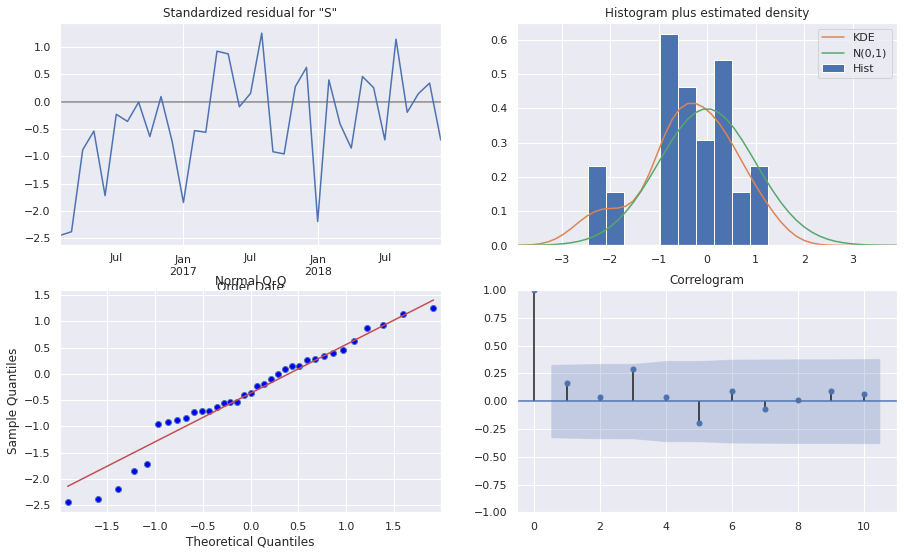

In [257]:
# _mod  = sm.tsa.statespace.SARIMAX(furniture_y,
#                                order=(1,1,1),
#                                seasonal_order= (1,1,1,12),
#                                enforce_invertibility=False)

# _results  = _mod.fit()

# sns.set(rc={'figure.figsize':(15,9)})
# plt.subplots_adjust(hspace = 0.8)
# _results.plot_diagnostics()
# plt.show()

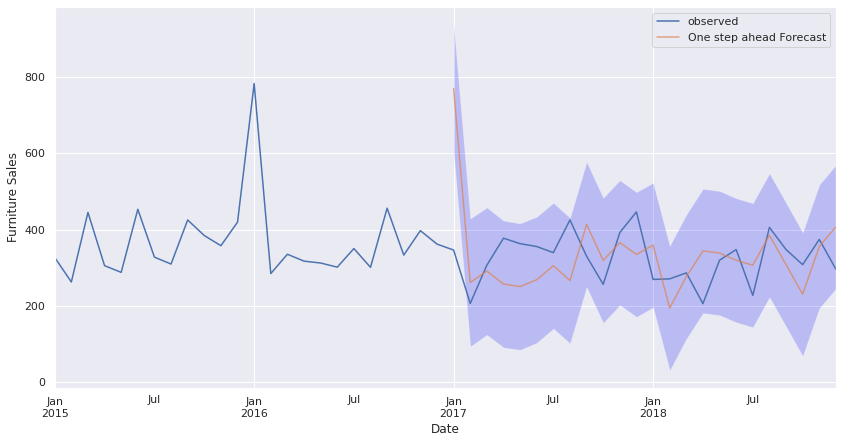

In [248]:
pred = results.get_prediction(start = pd.to_datetime('2017-01-01'), dynamic = False)
pred_ci = pred.conf_int()

ax = furniture_y['2014':].plot(label= 'observed')

pred.predicted_mean.plot(ax = ax, label = 'One step ahead Forecast',
                        alpha = .7, figsize= (14,7))

ax.fill_between(pred_ci.index,
               pred_ci.iloc[:,0],
               pred_ci.iloc[:,1], facecolor='blue', alpha= 0.2)

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()

plt.show()

In [249]:
furniture_forecasted = pred.predicted_mean
furn_truth = furniture_y['2017-01-01':]
mse = ((furniture_forecasted - furn_truth) ** 2).mean()

print('MSE of forecast : ${:0,.2f}'.format(mse))

MSE of forecast : $13,694.67


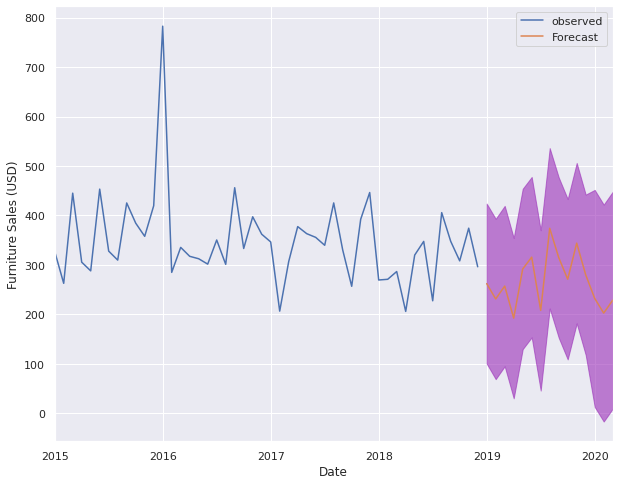

In [250]:
pred_uc = results.get_forecast(steps = 15)
pred_ci = pred_uc.conf_int()

ax = furniture_y.plot(label='observed', figsize=(10,8))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
               pred_ci.iloc[:,0],
               pred_ci.iloc[:,1],color='#9a2eb8',alpha=0.6)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales (USD)')

plt.legend()
plt.show()

In [251]:
# pred_uc = results.get_forecast(steps = 70)
# pred_ci = pred_uc.conf_int()
# pred_ci

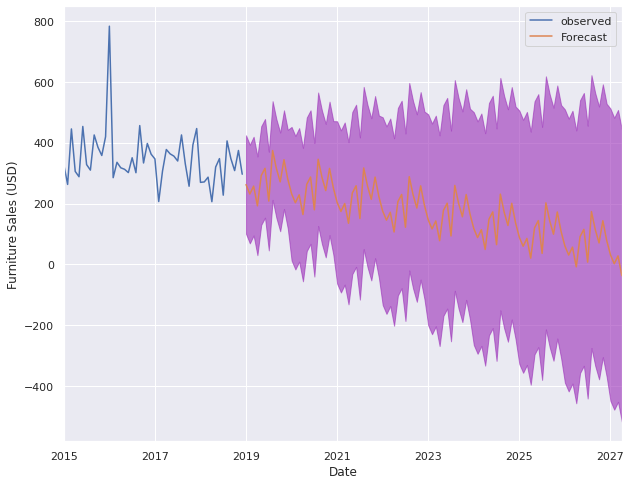

In [252]:
pred_uc = results.get_forecast(steps = 100)
pred_ci = pred_uc.conf_int()

ax = furniture_y.plot(label='observed', figsize=(10,8))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
               pred_ci.iloc[:,0],
               pred_ci.iloc[:,1],color='#9a2eb8',alpha=0.6)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales (USD)')

plt.legend()
plt.show()

Tương tự vói danh mục Furniture, ta thực hiện với các danh mục còn lại.
Dưới đây là đoạn code đẩy đủ để thực hiện triển khai API sau này.

In [253]:
# Full code cho category : Office Supplies

from datetime import date

cat = data.loc[data['Category']== 'Office Supplies']
o_s = cat.loc[:, ["Order Date", "Sales"]]
os = o_s.sort_values('Order Date')
os = os.set_index('Order Date')
os_y = os['Sales'].resample('MS').mean()
decomposition_os = sm.tsa.seasonal_decompose(os_y,model='additive')
p=d=q=range(0,2)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0],x[1],x[2], 12) for x in pdq]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(os_y,order = param, seasonal_order = param_seasonal ,
                                            enforce_stationarity= False , enforce_invertibility= False )
            results = mod.fit()            
            #print('ARIMA{} x {} 12 -- AIC : {}'.format(param, param_seasonal, results.aic))            
        except:
             continue

mod_os = sm.tsa.statespace.SARIMAX(os_y,
                               order=(1,1,1),
                               seasonal_order= (1,1,1,12),
                               enforce_stationarity = False,
                               enforce_invertibility=False)

results_os = mod_os.fit()

def GetMeanSale(startDate):
  pred_os = results_os.get_prediction(start = pd.to_datetime(startDate), dynamic = False)
  pred_ci_os = pred_os.conf_int()
  office_forecasted = pred_os.predicted_mean

  office_truth = os_y[startDate:]
  print(office_truth)
  mse = ((office_forecasted - office_truth) ** 2).mean()
  print('MSE of forecast : ${:0,.2f}'.format(mse))


In [254]:
from datetime import datetime
import json
def GetPredictionTo(endDate):
  dt1 = datetime.strptime("2018/01/01", "%Y/%m/%d")
  dt2 = datetime.strptime(str(endDate), "%Y/%m/%d")
  today = pd.to_datetime('today')
  steps = dt2 - dt1 if today > dt2 else (dt2 - today)
  # steps = dt2 - dt1
  return GetPrediction(steps.days)

def GetPrediction(steps = 100):
  print(steps)
  pred_uc = results_os.get_forecast(steps)
  pred_ci = pred_uc.conf_int()
  df = pd.DataFrame(data=pred_ci).reset_index().rename(columns={"index": "Date", "lower Sales" : "Lower_Sale", "upper Sales" : "Upper_Sales", })  
  return df

In [255]:
# Test dự đoán
toDate = "2024/01/01"
endDate = pd.to_datetime(toDate, format='%Y/%m/%d')
result = GetPredictionTo(endDate.strftime('%Y/%m/%d'))
# Convert the date to datetime64
result['Date'] = pd.to_datetime(result['Date'], format='%Y-%m-%d')

# In ra dự đoán từ ngày hiện tại đến toDate được nhập vào
print(result[(result['Date'] >= pd.to_datetime('today')) &  (result['Date'] <=endDate)])

425
         Date  Lower_Sale  Upper_Sales
47 2022-12-01   -6.037678   294.642408
48 2023-01-01   19.250363   346.933566
49 2023-02-01  -19.200717   310.529059
50 2023-03-01   -5.053182   324.829846
51 2023-04-01  -30.556693   299.335658
52 2023-05-01  -48.096820   281.796107
53 2023-06-01  -37.568807   292.324176
54 2023-07-01  -48.730028   281.162985
55 2023-08-01   13.864857   343.757905
56 2023-09-01  -28.975675   300.917414
57 2023-10-01  -16.897552   312.995583
58 2023-11-01  -29.086784   300.806414
59 2023-12-01  -16.856986   313.036583
60 2024-01-01    8.699062   365.059735


# Triển khai API

Source Code: https://github.com/khanh22mse23057/superstore-ales-api

GIT: https://github.com/khanh22mse23057/superstore-sales-api.git

## Prod API : https://superstore-sale-api.fsbmse11.live
#### API Doc:
##### https://superstore-sale-api.fsbmse11.live/docs
or
##### https://superstore-sale-api.fsbmse11.live/redoc
## Dev : http://localhost:8000/docs


[Screenshot1](https://prnt.sc/wY0A6bdd3QDt)

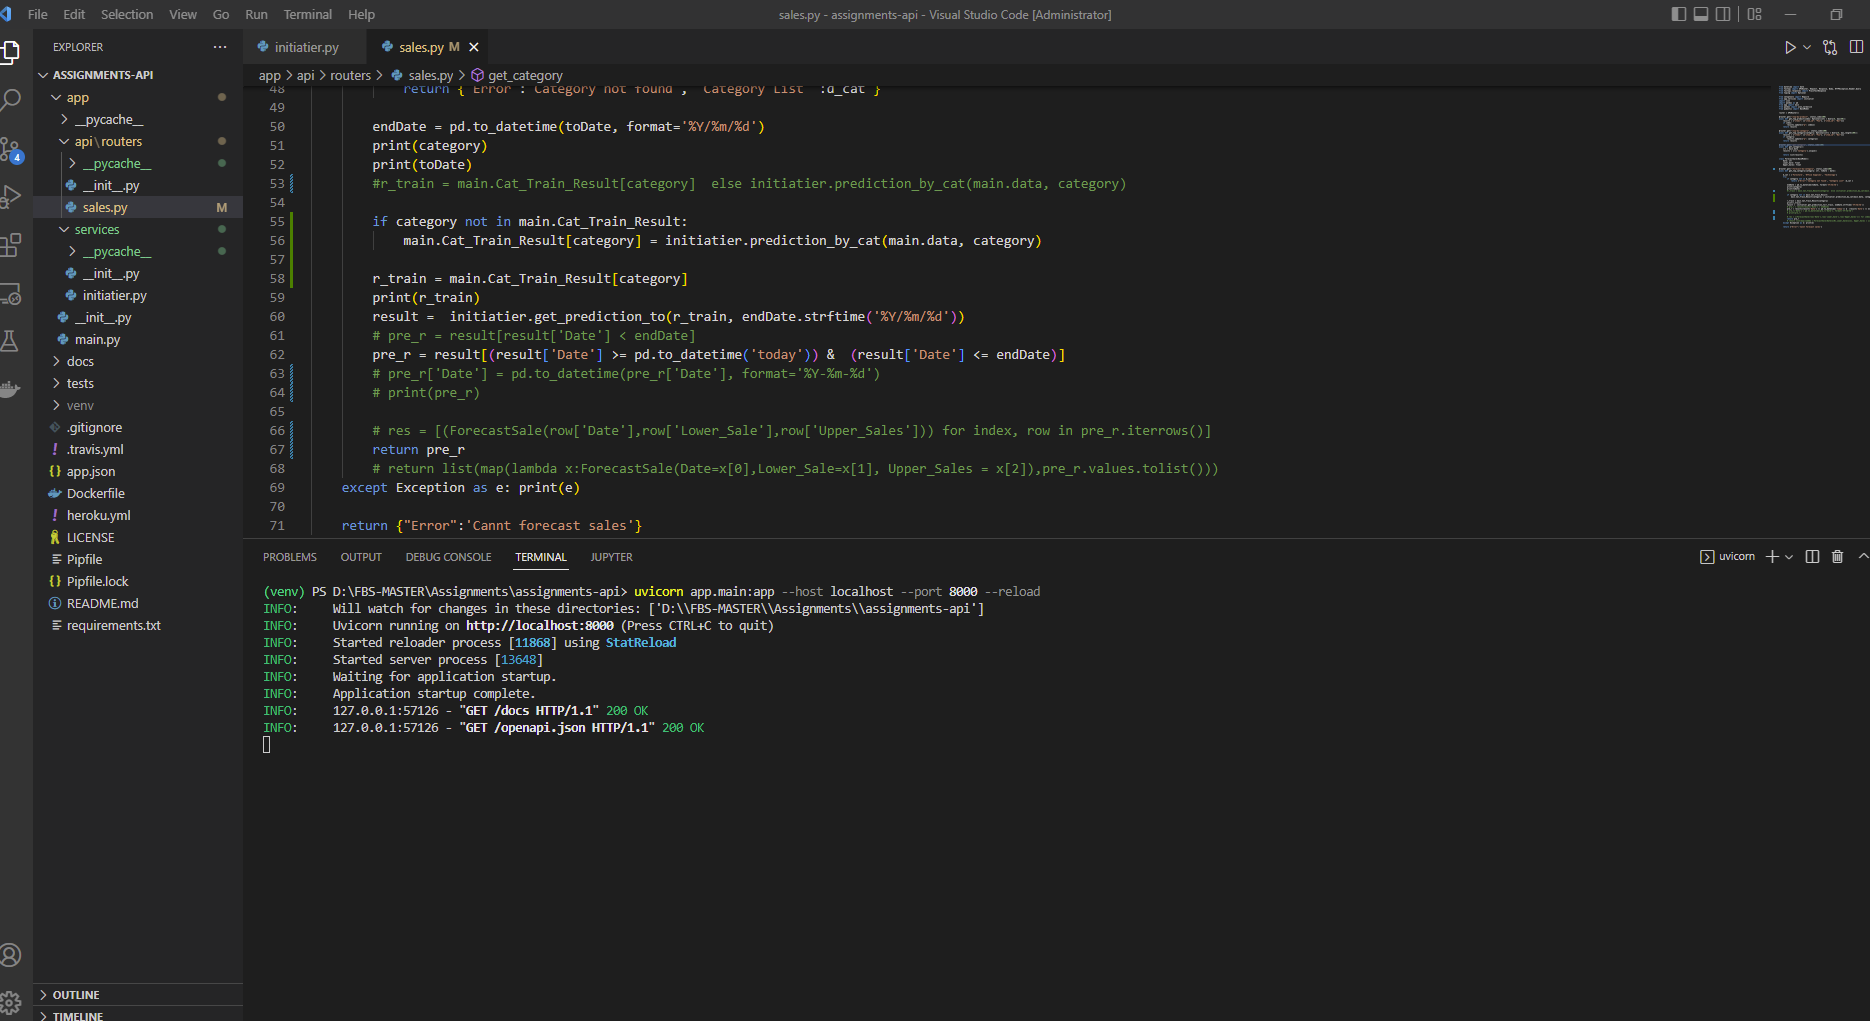

[Screenshot2](https://prnt.sc/qEm7sf3P5FZJ)

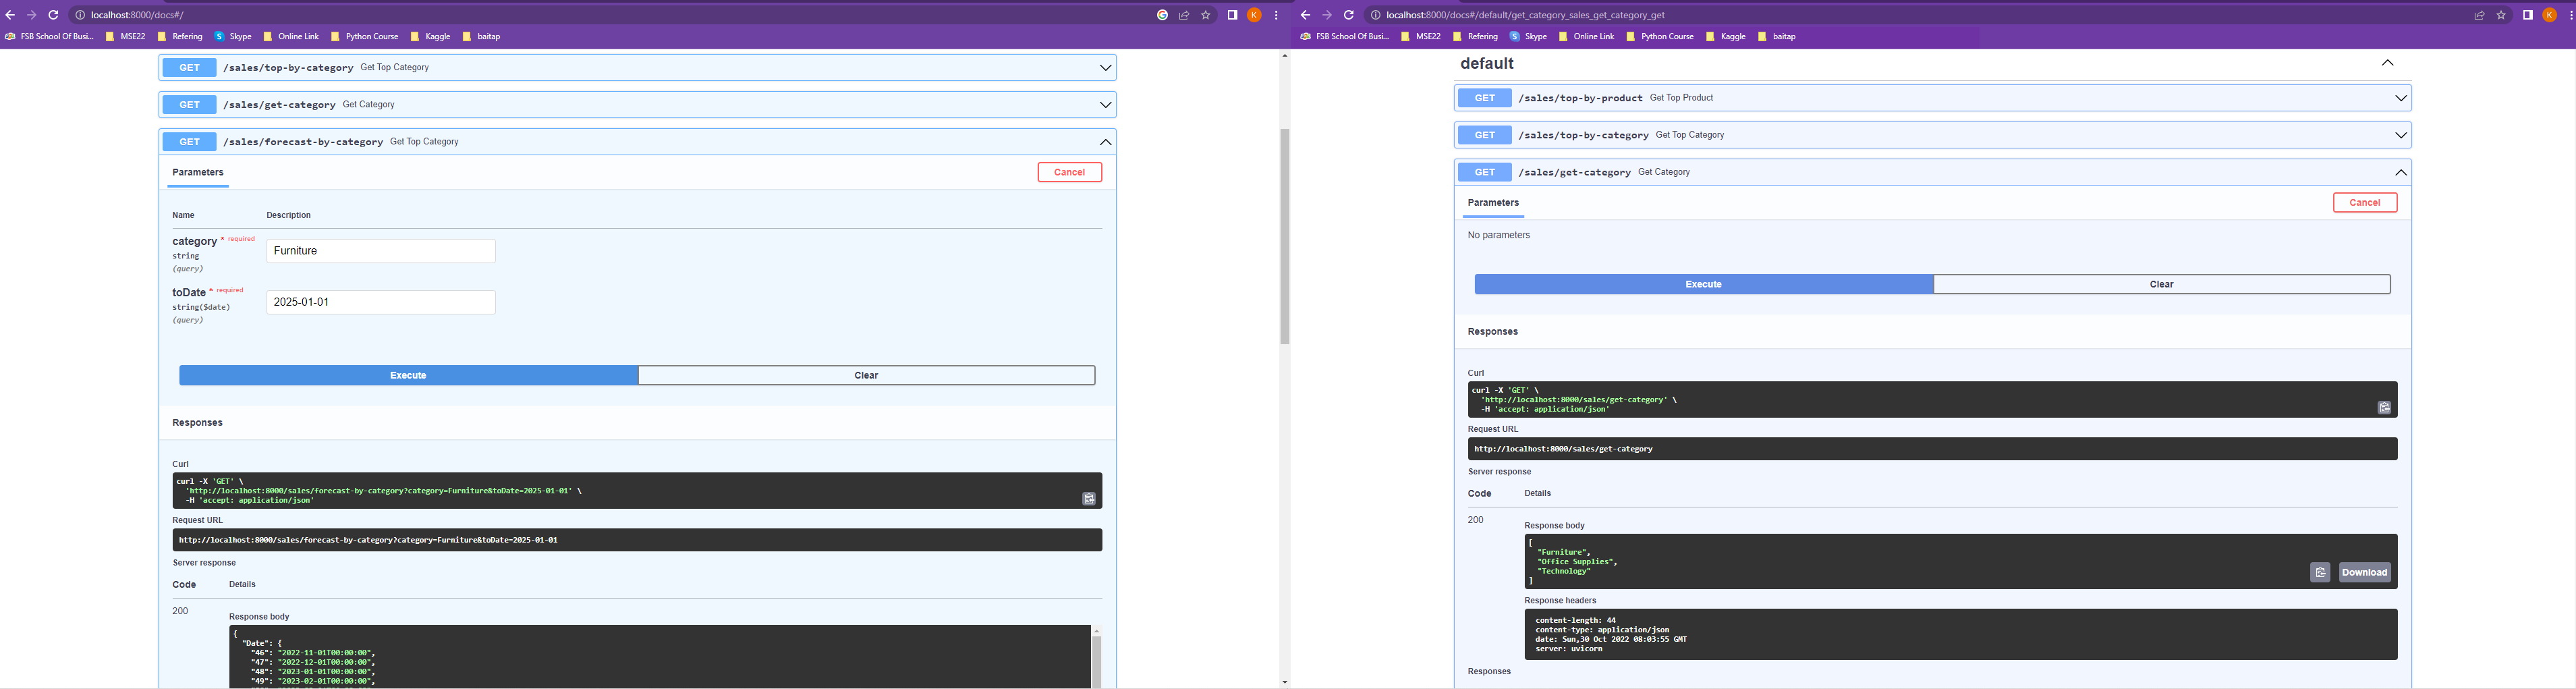

[Screenshot3](https://prnt.sc/vfFjpzE56ckh)
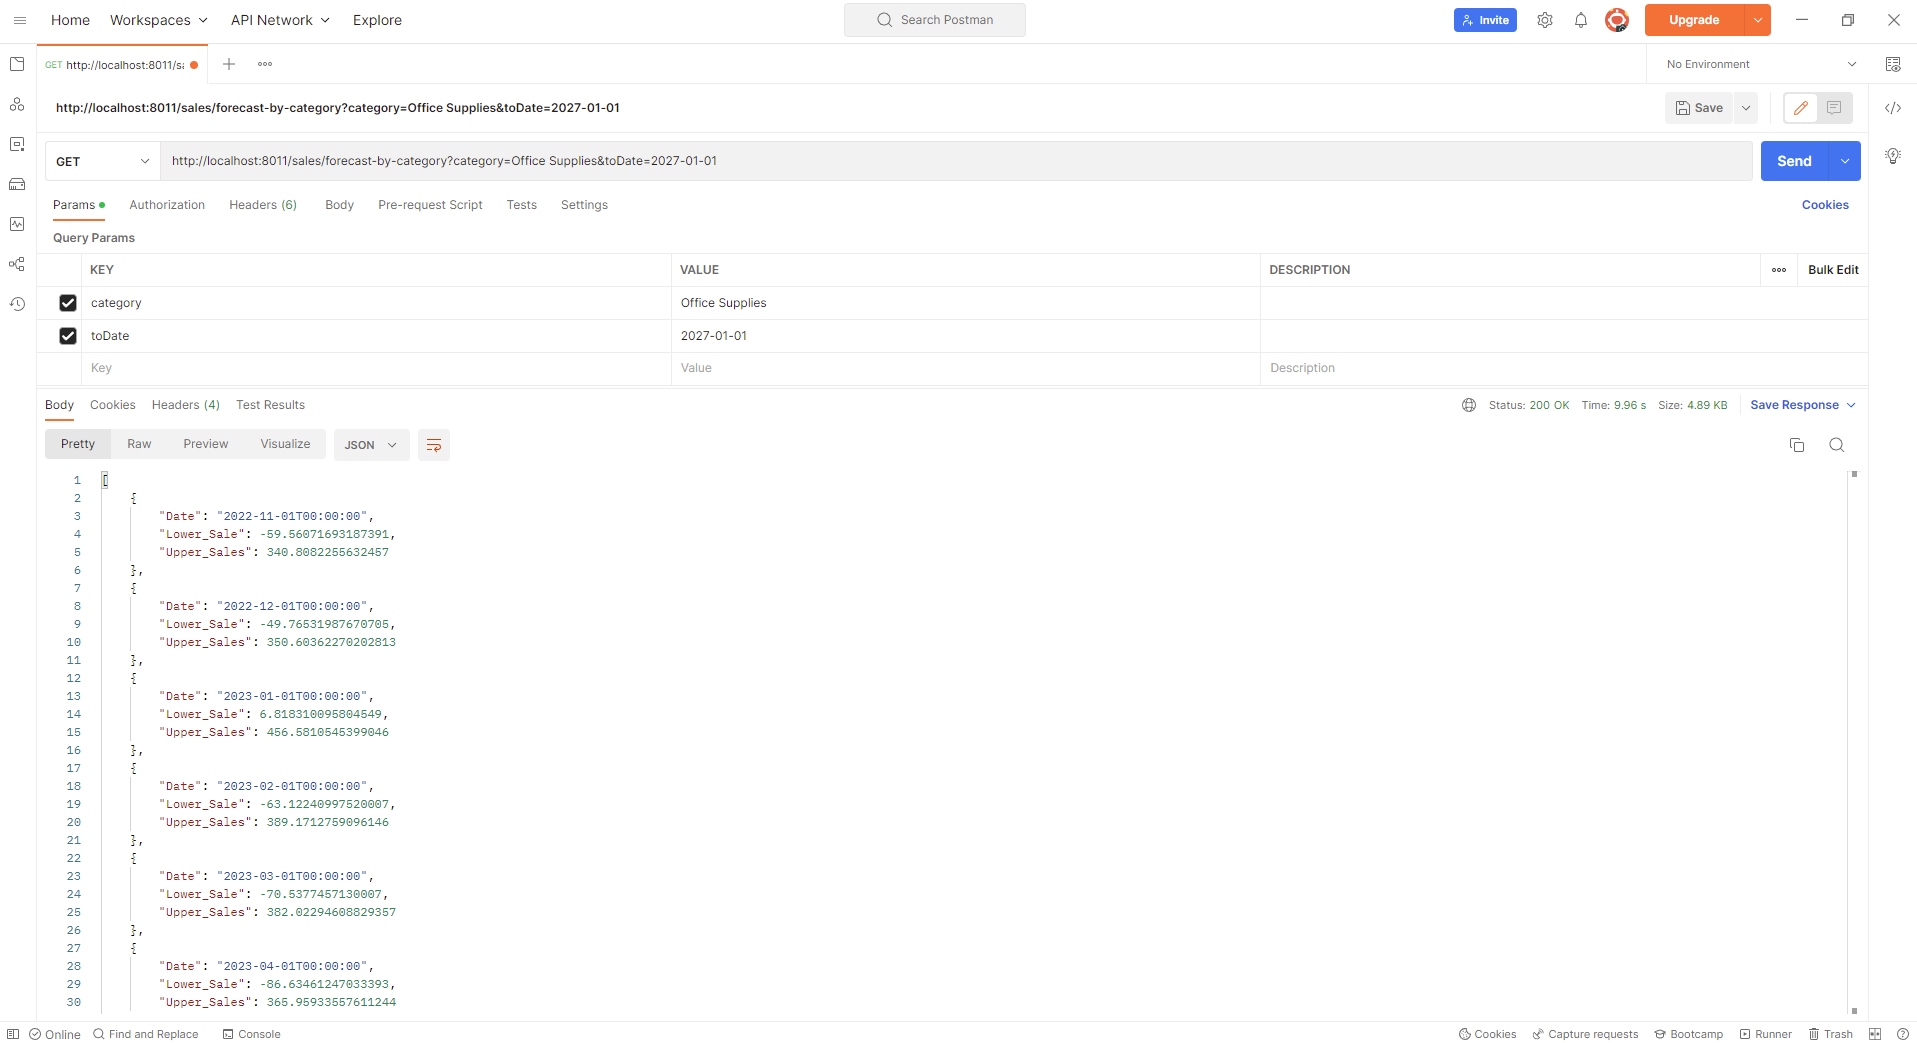

[Screenshot5](https://prnt.sc/PGsC9hYomwWd)
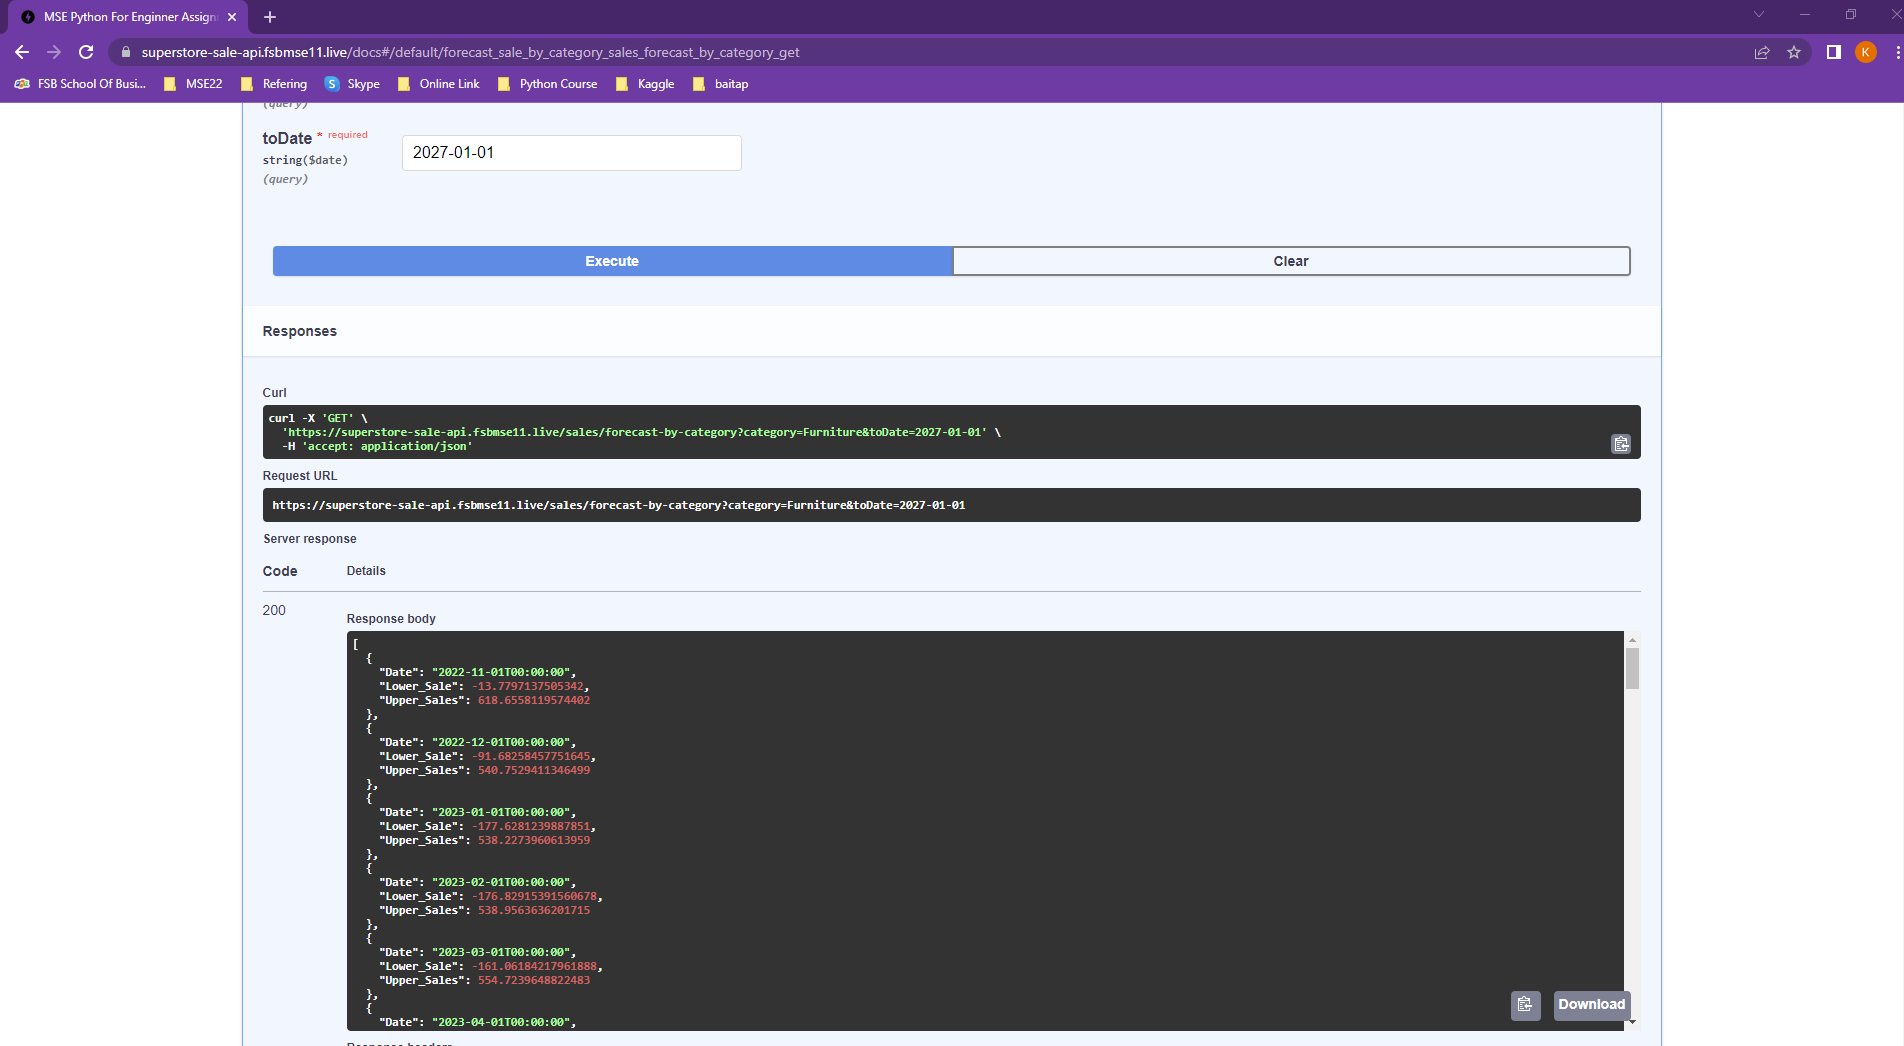